In [251]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.abspath("../"))
from src.helper import show_clustered_image, calculate_cmyk_percentage

In [204]:
df = pd.read_csv("../datasets/cmyk_by_dpi_and_render_options.csv")
df = df[(df['dpi'] == 5) & (df['options'] == 'default')]

# Reset the index
df.reset_index(drop=True, inplace=True)

df_clustered = pd.read_csv("../datasets/clustered_cmy_k_agglomerative_300dpi.csv")

# Add cmy column
df['cmy'] = df['c'] + df['m'] + df['y']
df['sum'] = df['cmy'] + df['k']

# Only use `cmy` and `k` column
df = df[['c', 'm', 'y', 'k', 'sum']]

# Add label column from df_clustered
df['label'] = df_clustered['label'].values

df

,c,m,y,k,sum,label
0,0.16,0.19,0.52,8.93,9.80,750
1,0.56,0.51,0.00,4.35,5.42,500
2,0.00,0.00,0.00,65.50,65.50,750
3,0.00,0.00,0.00,75.99,75.99,750
4,0.00,0.00,0.00,75.99,75.99,750
...,...,...,...,...,...,...
879,0.00,0.00,0.00,6.24,6.24,500
880,2.55,11.07,11.06,15.09,39.77,1500
881,0.81,1.20,1.84,1.35,5.20,500
882,4.67,27.89,29.58,16.01,78.15,2000


In [205]:
X = df.drop(columns='label')
y = df['label']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=0)

In [211]:
col_transformer = ColumnTransformer([
    ("scale", RobustScaler(), ['c', 'm', 'y', 'k', 'sum'])
])

rfc_params = {
    'classification__criterion': ["gini", "entropy", "log_loss"],
    'classification__class_weight': ["balanced", "balanced_subsample"],
    'classification__max_features' : ["sqrt", "log2"],
}

classification_pipe = Pipeline([
    ("transformer", col_transformer),
    ("classification", RandomForestClassifier())
])

model = GridSearchCV(classification_pipe, param_grid=rfc_params, cv=3, verbose=2)

model.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END classification__class_weight=balanced, classification__criterion=gini, classification__max_features=sqrt; total time=   0.2s
[CV] END classification__class_weight=balanced, classification__criterion=gini, classification__max_features=sqrt; total time=   0.2s
[CV] END classification__class_weight=balanced, classification__criterion=gini, classification__max_features=sqrt; total time=   0.2s
[CV] END classification__class_weight=balanced, classification__criterion=gini, classification__max_features=log2; total time=   0.2s
[CV] END classification__class_weight=balanced, classification__criterion=gini, classification__max_features=log2; total time=   0.2s
[CV] END classification__class_weight=balanced, classification__criterion=gini, classification__max_features=log2; total time=   0.2s
[CV] END classification__class_weight=balanced, classification__criterion=entropy, classification__max_features=sqrt; total time=   0.2

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scale',
                                                                         RobustScaler(),
                                                                         ['c',
                                                                          'm',
                                                                          'y',
                                                                          'k',
                                                                          'sum'])])),
                                       ('classification',
                                        RandomForestClassifier())]),
             param_grid={'classification__class_weight': ['balanced',
                                                          'balanced_subsample'],
                         'classification__criterion': ['gini', 'entropy',
                                                       'log_loss'],
                         'classification__max_features': ['sqrt', 'log2']},
             verbose=2)

In [212]:
y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         500       1.00      1.00      1.00        59
         750       1.00      1.00      1.00        18
        1000       0.98      0.97      0.97        86
        1500       0.98      0.98      0.98       123
        2000       1.00      1.00      1.00         6

    accuracy                           0.98       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.98      0.98      0.98       292



In [213]:
confusion_matrix(y_pred, y_test)

array([[ 59,   0,   0,   0,   0],
       [  0,  18,   0,   0,   0],
       [  0,   0,  83,   3,   0],
       [  0,   0,   2, 121,   0],
       [  0,   0,   0,   0,   6]])

array([ 500, 1500,  500,  500, 1500,  500, 1500, 1000, 1000, 1500, 2000,
        500, 1500,  500, 1500,  500, 1500, 1000, 1000,  750, 1000, 1000,
       1000, 1500,  750, 1000, 1500, 1000, 1000, 1500,  500, 1500, 1500,
        750, 1500,  500, 1500, 1500, 1500, 1500, 1500,  500, 1500, 2000,
       1500, 1500, 1500,  500, 1000, 1000, 1000,  500,  500, 1000,  500,
       1000, 1000, 1500,  500, 1500, 1500,  500,  500, 1000, 1500, 1500,
        750, 1500, 1500,  750,  500,  500, 1000, 1500,  500,  750, 1500,
       2000,  500, 1000, 1000, 1500,  500, 1500,  500, 1000,  500,  500,
       1500, 1500, 1000, 1000, 1500,  500, 1500, 1500, 1000, 1500, 1000,
       1000, 1500, 1000,  500, 1000, 1000, 1000, 1000,  750, 1500, 1500,
       1500, 1000, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,
        750,  500,  500, 1500, 1500,  500, 1500, 1500, 1000, 1500, 1500,
       1000, 1500,  750, 1500, 1500, 1500, 1000, 1500, 1500, 1000, 1500,
        500, 1000,  500,  500,  750,  750, 1000, 10

Text(50.722222222222214, 0.5, 'Predicted')

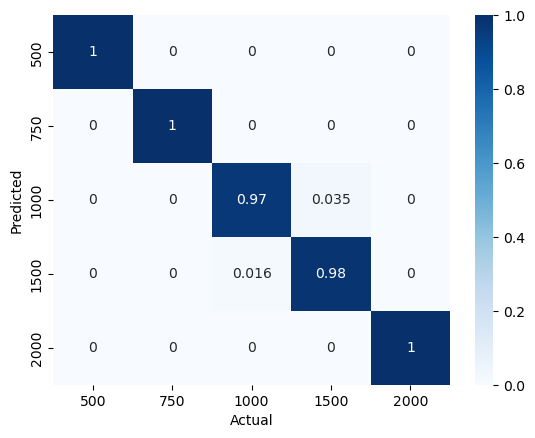

In [252]:
import numpy as np
sns.heatmap(
    confusion_matrix(y_pred, y_test, normalize='true', labels=np.unique(y_pred)),
    annot=True, cmap='Blues',
    xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [254]:
import pickle

pickle.dump(model, open("../models/random_forest_classifier_c_m_y_k_sum_5_dpi.pkl", 'wb'))
pickle.dump(model.best_estimator_, open("../models/random_forest_classifier_c_m_y_k_sum_5_dpi_small.pkl", 'wb'))